In [58]:
import pandas as pd

In [61]:
df = pd.read_csv('../datasets/df_flight_weather_8.csv')



<Axes: >

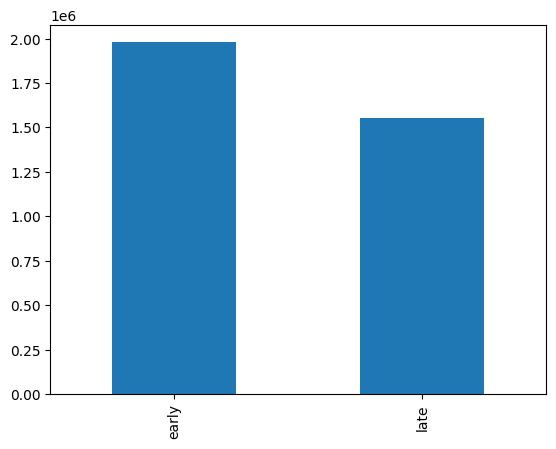

In [62]:
#drop na
df = df.dropna()
df['ARRIVAL_DELAY_CAT_2'] = df['ARRIVAL_DELAY_MIN_CAT'].apply(lambda x: 'early' if x < 0 else 'late')
#plot distribution of ARRIVAL_DELAY_MIN_CAT_2
df['ARRIVAL_DELAY_CAT_2'].value_counts().plot(kind='bar')

In [63]:
#columns
df.columns
# ARRIVAL_DELAY_MIN_CAT, DEPARTURE_DELAY_MIN', 'ARRIVAL_DELAY_MIN, remove

if 'ARRIVAL_DELAY_MIN_CAT' in df.columns:
    df.drop('ARRIVAL_DELAY_MIN_CAT', axis=1, inplace=True)
if 'ARRIVAL_DELAY_MIN' in df.columns:
    df.drop('ARRIVAL_DELAY_MIN', axis=1, inplace=True)
if 'DEPARTURE_DELAY_MIN' in df.columns:
    df.drop('DEPARTURE_DELAY_MIN', axis=1, inplace=True)

In [64]:
target = 'ARRIVAL_DELAY_CAT_2'
#count target values
df[target].value_counts()

early    1979077
late     1553577
Name: ARRIVAL_DELAY_CAT_2, dtype: int64

In [65]:
from typing import Dict, Tuple


def encode_categorical(df, cols_to_encode) -> Tuple[Dict[str, Dict], pd.DataFrame]:
    """
    Encode categorical columns in a DataFrame using numeric labels.

    Parameters:
        df (pandas.DataFrame): DataFrame containing the categorical columns to encode.
        cols_to_encode (list): List of column names to encode.

    Returns:
        dict: Mapping of categorical column names to dictionaries that map encoded values to string values.
    """
    encodings = {}
    for col in cols_to_encode:
        unique_vals = df[col].unique()
        encoding_dict = {}
        for i, val in enumerate(unique_vals):
            encoding_dict[i] = val
            encoding_dict[val] = i
        df[col] = df[col].apply(lambda x: encoding_dict[x])
        encodings[col] = encoding_dict
    return encodings, df


In [66]:

encoded_cols = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'ARRIVAL_DELAY_CAT_2']
# encoded_cols = df.select_dtypes(include=['object']).columns
encodings, df = encode_categorical(df, encoded_cols)

#save encodings as json file
# with open('encodings.json', 'w') as f:
#     json.dump(encodings, f)


In [69]:
import json
#decode categorical
with open('encodings.json', 'r') as f:
    encodings = json.load(f)

df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DAY_OF_YEAR,DAY_IND,TEMP,ICON_EXTD,...,WDIR_CARDINAL_DEST,WSPD_DEST,UV_DESC_DEST,FEELS_LIKE_DEST,UV_INDEX_DEST,CLDS_DEST,WX_PHRASE_SIMPLE_DEST,SCHEDULED_DEPATURE_HR,SCHEDULED_ARRIVAL_HR,ARRIVAL_DELAY_CAT_2
0,1,2,5,0,0,0,2,N,59.0,3300.0,...,W,13.0,Low,6.0,0.0,OVC,Cloudy,0,6,0
1,1,2,5,1,1,1,2,N,43.0,3300.0,...,E,5.0,Low,75.0,0.0,SCT,Partly Cloudy,0,8,0
2,1,2,5,2,2,2,2,N,56.0,3300.0,...,SW,18.0,Low,19.0,0.0,OVC,Cloudy,0,6,1
3,1,2,5,0,3,3,2,N,14.0,3300.0,...,NW,12.0,Low,41.0,0.0,BKN,Mostly Cloudy,0,6,1
4,1,2,5,0,4,0,2,N,38.0,3300.0,...,W,13.0,Low,6.0,0.0,OVC,Cloudy,0,5,1


In [70]:
#remove unnecessary columns
target = 'ARRIVAL_DELAY_CAT_2'
all_features = ['SCHEDULED_DEPATURE_HR', 'SCHEDULED_ARRIVAL_HR', 'AIRLINE', 'PRESSURE', 'PRESSURE_DEST', 'ORIGIN_AIRPORT', 'RH_DEST', 'RH', 'DESTINATION_AIRPORT', 'DEWPT_DEST', 'DEWPT', 'WC', 'FEELS_LIKE', 'WC_DEST', 'FEELS_LIKE_DEST', 'HEAT_INDEX', 'TEMP', 'TEMP_DEST', 'WDIR_DEST', 'HEAT_INDEX_DEST', 'WDIR', 'WSPD_DEST', 'WSPD', 'WDIR_CARDINAL', 'WDIR_CARDINAL_DEST']
# features is the top 21 features from the all_features list
features  = all_features[:11]
df = df[features + [target]]
df.head()

,SCHEDULED_DEPATURE_HR,SCHEDULED_ARRIVAL_HR,AIRLINE,PRESSURE,PRESSURE_DEST,ORIGIN_AIRPORT,RH_DEST,RH,DESTINATION_AIRPORT,DEWPT_DEST,DEWPT,ARRIVAL_DELAY_CAT_2
0,0,6,0,29.92,29.26,0,77.0,20.0,0,13.0,18.0,0
1,0,8,1,27.88,30.10,1,90.0,24.0,1,72.0,8.0,0
2,0,6,2,28.81,29.50,2,64.0,27.0,2,20.0,22.0,1
3,0,6,0,26.09,29.08,3,76.0,77.0,3,39.0,8.0,1
4,0,5,0,30.05,29.26,4,77.0,44.0,0,13.0,18.0,1


In [71]:
X = df[features]
y = df[target]

In [73]:
from collections import Counter
from imblearn.combine import SMOTEENN 

#SMOTEENN, it's a method that combines over-sampling and under-sampling. 
#It's a class to perform over-sampling using SMOTE and cleaning using ENN.

sme = SMOTEENN(random_state=42)
X_res, y_res = sme.fit_resample(X, y)

X, y = X_res, y_res 
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 635230, 1: 477355})


<Axes: >

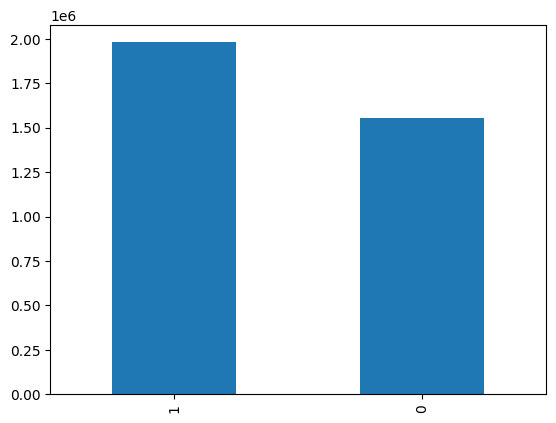

In [74]:
#plot distribution of ARRIVAL_DELAY_MIN_CAT_2
df[target].value_counts().plot(kind='bar')

In [75]:
#save as csv
df_res = pd.concat([X, y], axis=1)
#name columns
df_res.columns = features + [target]
df_res.to_csv('df_flight_weather_8b.csv', index=False)

In [76]:
#shape
X.shape

(1112585, 11)

In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [78]:
#run random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, criterion='entropy', n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Confusion matrix: ', confusion_matrix(y_test, y_pred))
print('Classification report: ', classification_report(y_test, y_pred))

Accuracy:  0.7126646503413222
Confusion matrix:  [[101239  25740]
 [ 38197  57341]]
Classification report:                precision    recall  f1-score   support

           0       0.73      0.80      0.76    126979
           1       0.69      0.60      0.64     95538

    accuracy                           0.71    222517
   macro avg       0.71      0.70      0.70    222517
weighted avg       0.71      0.71      0.71    222517



In [81]:
#grid search
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_params_ = grid_search.best_params_

#run the best model; whatever the best parameters are; use best_params_ to get the best parameters
rf = RandomForestClassifier(n_estimators=best_params_['n_estimators'], max_depth=best_params_['max_depth'], random_state=42, criterion=best_params_['criterion'], n_jobs=-1)

#save model
import pickle
#save model
with open('flight_delay_rf_v1.pkl', 'wb') as f:
    pickle.dump(rf, f)


Fitting 3 folds for each of 18 candidates, totalling 54 fits


KeyboardInterrupt: 

In [80]:
#save as pickle
import pickle
with open('flight_delay_rf_v0.pkl', 'wb') as f:
    pickle.dump(rf, f)
